In [1]:
# ---------------------------------------------------------------------------------------------- 
# the purpose of this code is to classify mnist data with convolutional neural network
# when i write this code, i refered to https://github.com/Hvass-Labs/TensorFlow-Tutorials
# I am not so good at English. So please be good to understand my awkward English. 
# ---------------------------------------------------------------------------------------------- 

In [2]:
# import modules
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [3]:
# import input_data
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/',one_hot = True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
# parameta
img_size = 28
img_shape = (28,28)
img_flat_length = 28*28*1
num_channels = 1 # black and white
filter_size1 = 5
num_filters1 = 16
filter_size2 = 5
num_filters2 = 32
fc_output1 = 128
fc_output2 = 64 
num_classes = 10
training_epoch = 32
batch_size = 100

In [5]:
# labels of True_test_Data
data_test_cls = np.argmax(data.test.labels,1)

In [6]:
# function for plotting images
def plot_img(images, data_true, data_pred = None):
    # debugging code 
    assert len(images) == len(data_true) == 9
    
    # make Function used to plot 9 images in a 3*3 grid
    fig,axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace = 0.3, wspace =0.3)
    
    for i,ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap = 'binary')
        
        if data_pred is None:
            xlabel = "True:{0}".format(data_true[i])
        else:
            xlabel = "True:{0}, Prediction:{1}".format(data_true[i], data_pred[i])
        ax.set_xlabel(xlabel)
        
        #Remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()   

In [7]:
# define function which makes convolutional network with relu and max_pooling layer.
def conv_layer(input,filter_size, num_channels,num_filters, use_maxpooling = True):
    shape = [filter_size,filter_size,num_channels,num_filters]
    weight = tf.Variable(tf.random_normal(shape), name ="weight")
    bias = tf.Variable(tf.random_normal([num_filters]), name = "bias")
    layer = tf.nn.conv2d(input,weight,strides = [1,1,1,1],padding = "SAME")
    layer += bias
    
    if use_maxpooling:
        layer = tf.nn.max_pool(layer,ksize = [1,2,2,1], strides = [1,2,2,1], padding ="SAME")
    
    return layer

In [8]:
# define flatting function for fully connected layer
def flatting(layer):
    layer_shape = layer.get_shape()
    length_layer = layer_shape[1:].num_elements()
    layer_flated = tf.reshape(layer,[-1,length_layer])
    
    return length_layer,layer_flated

In [9]:
# define function for making fully connceted layer.
def fully_connected(input, num_input,num_output,use_relu = True):
    weight1 = tf.Variable(tf.random_normal([num_input,num_output]))
    bias1 = tf.Variable(tf.random_normal([num_output]), name = "bias_fully")
    logits = tf.matmul(input,weight1)+ bias1
    
    if use_relu:
        logits = tf.nn.relu(logits)
    
    return logits

In [10]:
# placeholder
X = tf.placeholder(tf.float32, shape = [None,img_flat_length], name ="INPUT")
Y = tf.placeholder(tf.float32, shape = [None,num_classes], name ="Labels")
X_img = tf.reshape(X,[-1,img_size,img_size,num_channels])

In [11]:
# first convolutional layer 
conv_layer1 = conv_layer(input = X_img,
                         filter_size = filter_size1,
                         num_channels = num_channels,
                         num_filters = num_filters1,
                         use_maxpooling = True)

In [12]:
# second convolutional layer
conv_layer2 = conv_layer(input = conv_layer1,
                         filter_size = filter_size2,
                         num_channels = num_filters1,
                         num_filters = num_filters2,
                         use_maxpooling = True)

In [13]:
# flatten data for using fully_connected_layer
length, flat_data = flatting(conv_layer2)

In [14]:
# first fully connected layer
layer_fc1 = fully_connected(input = flat_data,
                            num_input = length,
                            num_output = fc_output1,
                            use_relu = True)

In [15]:
# Second fully connected layer
layer_fc2 = fully_connected(input = layer_fc1,
                            num_input = fc_output1,
                            num_output = fc_output2,
                            use_relu = True)

In [16]:
# final fully connected layer
layer_fc3 = fully_connected(input = layer_fc2,
                            num_input = fc_output2,
                            num_output = num_classes,
                            use_relu = False)

In [17]:
Y_pred = tf.nn.softmax(layer_fc3)

Y_pred_cls = tf.argmax(Y_pred,1)

In [18]:
# cross_entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = layer_fc3, labels = Y)
# cost function
cost = tf.reduce_mean(cross_entropy)
# we will use AdamOptimizer
optimizer = tf.train.AdamOptimizer(learning_rate = 2e-3).minimize(cost)

In [19]:
is_correct = tf.equal(Y_pred_cls,tf.argmax(Y,1))

Accuracy = tf.reduce_mean(tf.cast(is_correct, dtype = tf.float32))

In [20]:
# create Session and initialize all variables
sess = tf.Session()
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [21]:
# training
for epoch in range(training_epoch):
    cost_val = 0
    total_batch = int(data.train.num_examples/batch_size)
    for k in range(total_batch):
        batch_xs, batch_ys = data.train.next_batch(total_batch)
        c,_ = sess.run([cost,optimizer], feed_dict = {X:batch_xs, Y:batch_ys})
        cost_val += c/total_batch
    print("Epoch:{0}".format(epoch), "Cost_val:{0}".format(cost_val))

Epoch:0 Cost_val:2742.7966803533354
Epoch:1 Cost_val:364.68330546985965
Epoch:2 Cost_val:189.15237722917024
Epoch:3 Cost_val:111.05169261932373
Epoch:4 Cost_val:69.2578331617875
Epoch:5 Cost_val:47.287187738418524
Epoch:6 Cost_val:28.870992461551317
Epoch:7 Cost_val:19.51496156036691
Epoch:8 Cost_val:13.126241816431266
Epoch:9 Cost_val:12.245110109502606
Epoch:10 Cost_val:6.979998445951749
Epoch:11 Cost_val:6.7967699582095795
Epoch:12 Cost_val:5.131809255312171
Epoch:13 Cost_val:5.627765310296407
Epoch:14 Cost_val:3.289086319178305
Epoch:15 Cost_val:4.648551783607065
Epoch:16 Cost_val:4.580509715230561
Epoch:17 Cost_val:4.215251001884843
Epoch:18 Cost_val:3.1305839595717586
Epoch:19 Cost_val:2.8418059651725525
Epoch:20 Cost_val:2.52280446770824
Epoch:21 Cost_val:2.8491290623466727
Epoch:22 Cost_val:2.07450914410348
Epoch:23 Cost_val:2.096608684135064
Epoch:24 Cost_val:2.737486887677177
Epoch:25 Cost_val:2.01425163098129
Epoch:26 Cost_val:1.806057085003832
Epoch:27 Cost_val:1.8496469568

In [22]:
# calculate Accuracy
Accuracy_val,Y_pred_val,correct = sess.run([Accuracy,Y_pred_cls,is_correct], feed_dict = {X:data.test.images, Y:data.test.labels})
print("Accuracy is {0}".format(Accuracy_val))

Accuracy is 0.9804999828338623


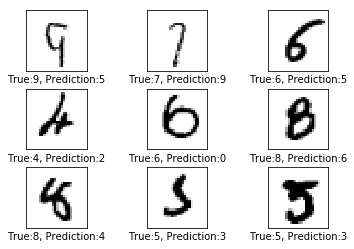

In [23]:
# plot examples of error
def plot_examples_error():
    
#--------search error location -----------------------    
    incorrect = (correct == False)
    
    q = data.test.images[incorrect]
    w = data_test_cls[incorrect]
    e = Y_pred_val[incorrect]
    
    q = q[0:9]
    w = w[0:9]
    e = e[0:9]
#--------------- end ---------------------------------
    # plotting images which have errors.
    plot_img(images = q, data_true=w, data_pred = e)

plot_examples_error()

[[ 970    0    1    1    0    0    5    0    2    1]
 [   0 1128    1    1    1    0    1    0    3    0]
 [   2    0 1019    0    1    1    0    2    6    1]
 [   1    0    5  993    0    2    0    3    4    2]
 [   1    0    1    0  958    2    6    1    1   12]
 [   1    0    0    7    0  878    2    0    2    2]
 [   5    2    0    1    4    7  935    0    4    0]
 [   2    6   13    1    2    1    0  997    1    5]
 [   3    0    5    4    3    0    4    1  951    3]
 [   2    2    1    2   11    5    1    5    4  976]]


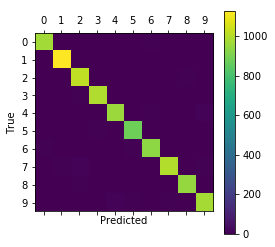

In [24]:
# create confusion matrix
def plot_confusion_matrix():
    data_true1 = data_test_cls
    data_pred1 = Y_pred_val
    
    cm = confusion_matrix(data_true1,data_pred1)
    
    print(cm)
    plt.matshow(cm)
    
    
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()

plot_confusion_matrix()